TODO: Pasamos de la clasificación, vamos a tratar el problema como uno de verificación de identidad, es decir, si dadas dos imágenes el modelo decide si ambas imágenes corresponden a la misma persona o no. Luego en la evaluación podemos calcular la distancia entre ellas y comparar. Ver ejemplo de *dissimilarity* en el notebook de siamesas con pytorch.

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import LFWPairs
from sklearn.model_selection import train_test_split
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

In [148]:
# Definir la red siamesa
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Identity()  # Removemos la capa final para obtener las características
        self.fc = nn.Linear(512, 256)  # Capa adicional para reducir las características

    def forward_one(self, x):
        x = self.resnet18(x)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

In [149]:
# Definir la función de pérdida Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.pairwise_distance(output1, output2)
        loss = 0.5 * (label.float() * torch.pow(euclidean_distance, 2) +
                      (1 - label).float() * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss.mean()

In [152]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Cargar el dataset LFW
train_dataset = LFWPairs(root='./data', split='train', transform=transform, download=True)
test_dataset = LFWPairs(root='./data', split='test', transform=transform, download=True)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


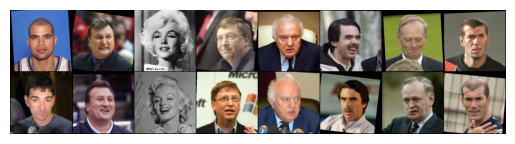

[0 1 1 1 1 1 1 1]


In [153]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iterations, losses):
    plt.plot(iterations, losses)
    plt.show()

dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

example_batch = next(iter(dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [154]:
model = SiameseNetwork().cuda()
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [158]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            optimizer.zero_grad()

            # Forward pass
            output1, output2 = model(img1, img2)

            euclidean_distance = torch.pairwise_distance(output1, output2)

            if i % 10 == 0:  # Imprimir cada 10 iteraciones
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Avg. Euclidean Distance: {euclidean_distance.mean().item()}')

            # Calcular la pérdida
            loss = criterion(output1, output2, label)

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [159]:
def evaluate(model, test_loader, threshold):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()

            # Forward pass
            output1, output2 = model(img1, img2)

            # Calcular la pérdida
            euclidean_distance = torch.pairwise_distance(output1, output2)
            predictions = (euclidean_distance < threshold).float()  # Usamos un umbral para clasificación

            total_samples += label.size(0)
            total_correct += (predictions == label).sum().item()

    accuracy = total_correct / total_samples
    print(f'Accuracy: {accuracy * 100:.2f}%')

In [160]:
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Batch [1/69], Avg. Euclidean Distance: 8.343301773071289
Epoch [1/10], Batch [11/69], Avg. Euclidean Distance: 6.802794456481934
Epoch [1/10], Batch [21/69], Avg. Euclidean Distance: 5.013288497924805
Epoch [1/10], Batch [31/69], Avg. Euclidean Distance: 3.2787089347839355
Epoch [1/10], Batch [41/69], Avg. Euclidean Distance: 2.2364389896392822
Epoch [1/10], Batch [51/69], Avg. Euclidean Distance: 1.6056017875671387
Epoch [1/10], Batch [61/69], Avg. Euclidean Distance: 1.3895666599273682
Epoch [1/10], Loss: 4.0052
Epoch [2/10], Batch [1/69], Avg. Euclidean Distance: 1.1577790975570679
Epoch [2/10], Batch [11/69], Avg. Euclidean Distance: 1.0425653457641602
Epoch [2/10], Batch [21/69], Avg. Euclidean Distance: 1.0106017589569092
Epoch [2/10], Batch [31/69], Avg. Euclidean Distance: 0.916641116142273
Epoch [2/10], Batch [41/69], Avg. Euclidean Distance: 0.8881769180297852
Epoch [2/10], Batch [51/69], Avg. Euclidean Distance: 0.8144106864929199
Epoch [2/10], Batch [61/69], A

In [161]:
evaluate(model, test_loader, 0.6)

Accuracy: 80.90%
